In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import time
from matplotlib.animation import FuncAnimation

In [3]:
try_number = 5
path = 'Backward/'

In [4]:
T = 0.1
field_size = 150
time_duration = 100

t = T / time_duration
h = 1 / (field_size - 1)
u = np.zeros((field_size, field_size, time_duration))

In [18]:
def phi(x, y):
    # Method animation1 
    # return np.sin(np.pi * x) * np.sin(np.pi * y)
    # test1 return 50 * np.exp(-(x - 1/2) ** 2 - (y - 1/2) ** 2)
    # test2  return np.sin(x + y)
    # test3 return 50 * np.exp((-(x - 1/4) ** 2 - (y - 1/3) ** 2) / 0.1)
    # test4 return 10 * x + 5 * y + 2.5
    # test5 
    return x + y

def g(x, y, t):
    # Method animation1 return 0
    # test1 return 500 * t
    # test2 return np.cos(x + y + t
    # test3 return 50 * np.sin(100 * t)
    # test4 return 50 * np.sin(10 * x + 10 * y)
    # test5 
    return 1 / np.cosh(10 * ((x - 1 / 2) + (y - 1 / 2)))

In [19]:
def generate_A(n, h, t):
    A = np.eye((n * n), dtype='float')
    for i in range(1, n - 1):
        for j in range(1, n - 1):
            row = n * j + i
            A[row][n * j + i] = h ** 2 + 4 * t
            A[row][n * j + (i - 1)] = -t
            A[row][n * j + (i + 1)] = -t
            A[row][n * (j - 1) + i] = -t
            A[row][n * (j + 1) + i] = -t
    return A
            

def generate_b(u, n, h, t, k):
    b = np.zeros((n, n))
    
    boundary_mask = np.zeros((n, n), dtype=bool)
    boundary_mask[0, :] = boundary_mask[-1, :] = True
    boundary_mask[:, 0] = boundary_mask[:, -1] = True
    
    inner_mask = ~boundary_mask
    i, j = np.where(boundary_mask)
    b[boundary_mask] = g(i * h, j * h, k * t)
    
    b[inner_mask] = h ** 2 * u[inner_mask][:, k]
    b = b.ravel()
    
    return b

In [20]:
A = csr_matrix(generate_A(field_size, h, t))

In [21]:
def Solution():
    for i in range(field_size):
        for j in range(field_size):
            if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
                u[i][j][0] = g(i * h, j * h, 0)
            else:
                u[i][j][0] = phi(i * h, j * h)
    
    for k in range(1, time_duration):
        b = generate_b(u, field_size, h, t, k - 1)
        y = spsolve(A, b)
        u[:, :, k] = y.reshape(field_size, field_size)

In [22]:
Solution()

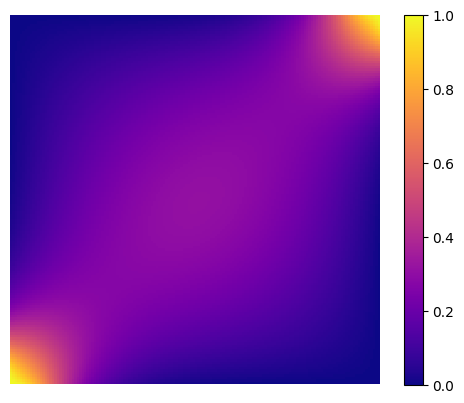

In [24]:
fig, ax = plt.subplots()
frames = time_duration - 3
interval = 100
heatmap = ax.imshow(u[:, :, 0], cmap='plasma', interpolation='nearest', vmin = 0, vmax = 1)

def update(frame):
    heatmap.set_array(u[:, :, frame - 1])
    return [heatmap]

plt.colorbar(heatmap)
plt.axis('off')
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(path + f'test{try_number}.gif', writer=PillowWriter(fps=10))

In [232]:
u_solve = np.zeros_like(u)
R = np.zeros_like(u)

def solve(x, y, t):
    return np.exp(-2 * np.pi ** 2 * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

In [233]:
def create_u_solve_and_R():
    global max_R
    global time_R
    for k in range(time_duration):
        for i in range(field_size):
            for j in range(field_size):
                u_solve[i, j, k] = solve(i * h, j * h, k * t)
                R[i, j, k] = abs(u_solve[i, j, k] - u[i, j, k])
                if R[i, j, k] > max_R:
                    max_R = R[i, j, k]
                    time_R = k
                    

In [234]:
max_R = 0.0
time_R = 0.0
create_u_solve_and_R()

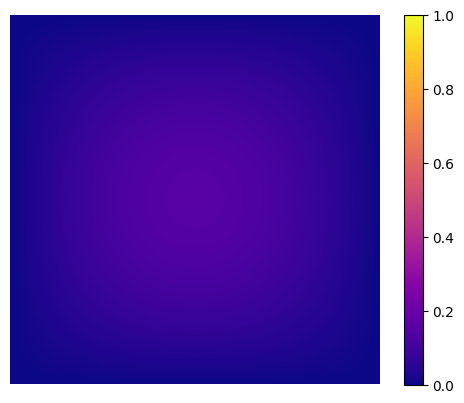

In [235]:
fig, ax = plt.subplots()
frames = time_duration - 3
interval = 100
heatmap = ax.imshow(u[:, :, 0], cmap='plasma', interpolation='nearest', vmin = 0, vmax = 1)

def update(frame):
    heatmap.set_array(u_solve[:, :, frame - 1])
    return [heatmap]

plt.colorbar(heatmap)
plt.axis('off')
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(path + f'solve animation{try_number}.gif', writer=PillowWriter(fps=10))

In [236]:
print(f'Максимальная погрешность равна {max_R} на итерации {time_R}')

Максимальная погрешность равна 0.0036143854943569975 на итерации 51


MovieWriter imagemagick unavailable; using Pillow instead.


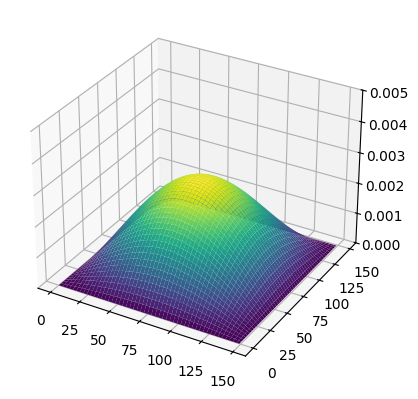

In [239]:
x = np.arange(field_size)
y = np.arange(field_size)
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 0.005)

# Начальное значение поверхности
z = R[:, :, 0]
surf = ax.plot_surface(x, y, z, cmap='viridis')

def update(frame):
    ax.clear()
    ax.set_zlim(0, 0.005)
    z = R[:, :, frame]
    surf = ax.plot_surface(x, y, z, cmap='viridis')
    return surf,

ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save(path + f'Error animation{try_number}.gif', writer='imagemagick', fps=15)
plt.show()


## Раздел 4. Сравнение численных методов Эйлера.

#### 1. Явный метод Эйлера.

Решение с помощью явного метода Эйлера является легким и понятным, но не является практичным, так как важно сохранять соотношение t к h как 1 к 100, то есть размер в 100000 матрицы больше, чем конечное время. 

После решения задачи с помощью явного метода Эйлера можно выделить некоторые плюсы решения этим методом:

1) Построение решения является понятным и легким.

2) После построение решения реализация также является легкой и понятной.

Но главным минусом является ограниченный круг абсолютной сходимости метода. Важно сохранять отношение t к h как 1 к 100. Рассмотрим как это влияет:

$t = \frac{T}{N}$, где T - 

Никита я не понимаю, что написать...